In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from openbb import obb
obb.user.preferences.output_type = "dataframe"

In [6]:
# Finding hedge ratio and entry exit conditions
pairs = ["GLD", "GDX"]
df = obb.equity.price.historical(
    pairs,
    start_date="2020-01-01",
    end_date="2025-08-31",
    provider="yfinance"
).pivot(columns="symbol", values="close")

trainset_range = 900
model = sm.OLS(df[pairs[0]].iloc[:trainset_range],
             df[pairs[1]].iloc[:trainset_range]) # ordinary least squares 
results = model.fit()
hedgeRatio = results.params.iloc[0] # gradient of GLD against GDX
print("hedgeRatio:", hedgeRatio)

# Buying a spread is defined as buying pair 0 and shorting hedgeRatio * pair 1
df["spread"] = df[pairs[0]] - hedgeRatio*df[pairs[1]]

spreadMean = np.mean(df["spread"].iloc[:trainset_range])
print("spreadMean: ", spreadMean)
spreadStd = np.std(df["spread"].iloc[:trainset_range])
print("spreadStd:", spreadStd)
df['zscore'] = (df["spread"]-spreadMean)/spreadStd
df['pair_0_Long'] = 0
df['pair_1_Long'] = 0
df['pair_0_Short'] = 0
df['pair_1_Short'] = 0
df.loc[df.zscore >= 0.5, ('pair_0_Short', 'pair_1_Short')] = [-1, 1]  # Short spread
df.loc[df.zscore <= -0.5, ('pair_0_Long', 'pair_1_Long')] = [1, -1]  # Buy spread
df.loc[df.zscore < 0, ('pair_0_Short', 'pair_1_Short')] = 0  # Exit short spread
df.loc[df.zscore > 0, ('pair_0_Long', 'pair_1_Long')] = 0  # Exit long spread
df.ffill(inplace=True)  # ensure existing positions are carried forward unless there is an exit signal
df.head()


OpenBBError: 
[Unexpected Error] -> YFDataException -> Yahoo API requires curl_cffi session not <class 'requests.sessions.Session'>. Solution: stop setting session, let YF handle.

In [ ]:
# Derive resulting positions

df['pair_0_net'] = df['pair_0_Long'] + df['pair_0_Short']
df['pair_1_net'] = df['pair_1_Long'] + df['pair_1_Short']
df[['pair_0_ret', 'pair_1_ret']] = df[[pairs[0], pairs[1]]].pct_change()
df['strategy_returns'] = (df['pair_0_net'].shift() * df['pair_0_ret'] +
                          df['pair_1_net'].shift() * df['pair_1_ret'])
df['strategy_return'] = df['strategy_returns'].fillna(0)

sharpeTrainset: 0.8633551264043249
sharpeTestset: 0.4310668097232197


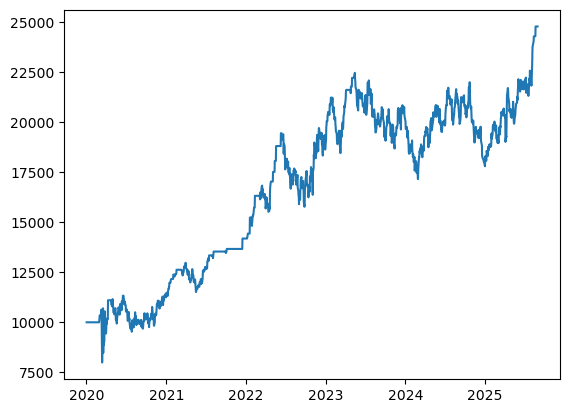

In [ ]:
# Trainset and Testset Sharpe Ratios

sharpeTrainset = np.sqrt(252) * np.mean(df['strategy_return'].iloc[:trainset_range]) / np.std(df['strategy_return'].iloc[:trainset_range])
print("sharpeTrainset:", sharpeTrainset)
sharpeTestset = np.sqrt(252) * np.mean(df['strategy_return'].iloc[trainset_range:]) / np.std(df['strategy_return'].iloc[trainset_range:])
print("sharpeTestset:", sharpeTestset)

cumret = np.cumprod(1 + df['strategy_return']) 
plt.plot(cumret*10000)
plt.show()

In [ ]:
from _03_drawdowns import calculateMaxDD

maxDD, maxDDD, startDDDay = calculateMaxDD(cumret.values)
print("maxDD:", maxDD)
print("maxDDD:", maxDDD)
print("Start of DD:", startDDDay)


maxDD: -0.16362992499776163
maxDDD: 549.0
Start of DD: 1045
